# Medical Image Segmentation and Applications(MISA) Final Project
*A highly oppiniated and biased tutorial on MRI lesion segmentation using Pytorch*

Developed by:
**Sergi Valverde, PhD**
*Universitat de Girona, Spain*

Modified by:
**Ahmed Gouda, MAIA**
*Universitat de Girona, Spain*



# Introduction:

---

During this part of the tutorial, we will focus entirely on MRI image segmentation using the U-NET architecture. This second part is structured as follows:

1. The U-NET model
2. Data preparation
3. Training the network
4. Inference
5. Evaluation
6. Conclusion

First of all, import or install all necessary libraries. We will make use of [ANTS](https://github.com/ANTsX/ANTsPy), which is like a super-power to manage and process `nifti` images. 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install https://github.com/ANTsX/ANTsPy/releases/download/v0.1.8/antspy-0.1.7-cp36-cp36m-linux_x86_64.whl
!pip install statsmodels
!pip install barbar
import os
import random
import torch
import ants
import numpy as np
import matplotlib.pyplot as plt
from barbar import Bar

# upload files (weird)
!git clone https://github.com/sergivalverde/MAIA_seminar.git

%load_ext autoreload
%autoreload 2

fatal: destination path 'MAIA_seminar' already exists and is not an empty directory.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Initialize the Parameters

In [0]:
#1 Adadelta Optimizer
#2 Adam Optimizer
OPTIMIZER_FUNCTION = 2

#1 Cross Entropy Loss
#2 Dice Loss
LOSS_FUNCTION = 2

#1 U-Net 3 Layers
#2 U-Net 3 Layers with BatchNormaliztion
#3 U-Net 3 Layers with BatchNormaliztion and Dropouts
#4 U-Net 4 Layers with BatchNormaliztion and Dropouts
#5 Modified U-Net
#6 Residual U-Net
#7 R2U-Net
#8 Nested Unet
UNET_TYPE = 5

#'standard','zero_one'
NORMALIZATION_TYPE = 'standard'

DATA_AUGMENTATION = True
NUMBER_OF_EPOCHS = 5

BLOCK_STEP_SIZE = 8   #8
BATCH_SIZE = 128

NUMBER_OF_LABELS = 4

# 1. The U-NET model: 
---

Let's now introduce the U-NET model. The encoder-decoder U-NET model was proposed by [Ronneberger et al. 2015](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/) in the context of biomedical image segmentation (microscopy imaging). Encoder-decoder models are very similar to [autoencoders](https://en.wikipedia.org/wiki/Autoencoder), so the encoding part compresses the input image into the latent space, meaning that we end up with a very efficient compressed version of the image with a lot less information (feauture space? 🤔). 

Based on the latent space, the decoder part reconstructs the image back. Compared to other encoder-decoder architectures like the [SegNET](https://mi.eng.cam.ac.uk/projects/segnet/), the U-NET model introduced the copy and crop elements, so activations for each of the encoder layers were concatenated (or added) to the same level decoding layers in order to help to reconstruct the image structure prior to segmentation. 

<img src="https://miro.medium.com/max/2640/1*J3t2b65ufsl1x6caf6GiBA.png" width="600" height="600" />

Although the original U-NET was proposed for 2D images, very rapidly 3D implementations arised [Çiçek et al. 2016](https://arxiv.org/abs/1606.06650). However, dealing with entire MRI volumes is not always possible, due to hardware memory limitations, etc... So, in most cases, patch-wise implementations of the same 3D models are used for different tasks such as brain tissue segmentation [Bernal et al. 2019](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8754679). For our problem in hand, we are going to follow the same 3D patch-wise approach. 

Let's now define our first patch-wise `Unet` model in PyTorch:

##U-Net 3 Layers with Batch Normaliztion


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet_3_Layers(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet_3_Layers, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool3(x3)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))
        
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7), dim=1) 
        return out

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet_3_Layers_BN(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet_3_Layers_BN, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        
        self.bn1 = nn.BatchNorm3d(32)

        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        
        self.bn2 = nn.BatchNorm3d(64)

        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        
        self.bn3 = nn.BatchNorm3d(128)

        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        self.bn4 = nn.BatchNorm3d(256)

        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        self.bn5 = nn.BatchNorm3d(128)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        self.bn6 = nn.BatchNorm3d(64)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        self.bn7 = nn.BatchNorm3d(32)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1bn = self.bn1(x1)
        x1p = self.pool1(x1bn)
        x2 = F.relu(self.conv2(x1p))
        x2bn = self.bn2(x2)
        x2p = self.pool2(x2bn)
        x3 = F.relu(self.conv3(x2p))
        x3bn = self.bn3(x3)
        x3p = self.pool3(x3bn)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))
        x4bn = self.bn4(x4)

        # decoder
        up1 = self.up1(x4bn)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        x5bn = self.bn5(x5)
        up2 = self.up2(x5bn)
        x6 = F.relu(self.conv6(up2 + x2))
        x6bn = self.bn6(x6)
        up3 = self.up3(x6bn)
        x7 = F.relu(self.conv7(up3 + x1))
        x7bn = self.bn7(x7)
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7bn), dim=1) 
        return out

##U-Net 3 Layers with Batch Normaliztion and Dropouts

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet_3_Layers_BN_DO(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet_3_Layers_BN_DO, self).__init__()

        self.dropout = nn.Dropout3d(0.5) 

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        
        self.bn1 = nn.BatchNorm3d(32)

        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        
        self.bn2 = nn.BatchNorm3d(64)

        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        
        self.bn3 = nn.BatchNorm3d(128)

        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        self.bn4 = nn.BatchNorm3d(256)

        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        self.bn5 = nn.BatchNorm3d(128)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        self.bn6 = nn.BatchNorm3d(64)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        self.bn7 = nn.BatchNorm3d(32)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1bn = self.bn1(x1)
        x1p = self.dropout(self.pool1(x1bn))

        x2 = F.relu(self.conv2(x1p))
        x2bn = self.bn2(x2)
        x2p = self.dropout(self.pool2(x2bn))

        x3 = F.relu(self.conv3(x2p))
        x3bn = self.bn3(x3)
        x3p = self.dropout(self.pool3(x3bn))
        
        # latent space
        x4 = F.relu(self.dropout(self.conv4(x3p)))
        x4bn = self.bn4(x4)

        # decoder
        up1 = self.up1(x4bn)
        x5 = F.relu(self.dropout(self.conv5(up1 + x3))) # look how layers are added :o
        x5bn = self.bn5(x5)

        up2 = self.up2(x5bn)
        x6 = F.relu(self.dropout(self.conv6(up2 + x2)))
        x6bn = self.bn6(x6)

        up3 = self.up3(x6bn)
        x7 = F.relu(self.dropout(self.conv7(up3 + x1)))
        x7bn = self.bn7(x7)
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7bn), dim=1) 
        return out

##U-Net 4 Layers with Batch Normaliztion and Dropouts

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet_4_Layers_BN_DO(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet_4_Layers_BN_DO, self).__init__()

        self.dropout = nn.Dropout3d(0.5) 

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        
        self.bn1 = nn.BatchNorm3d(32)

        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        
        self.bn2 = nn.BatchNorm3d(64)

        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        
        self.bn3 = nn.BatchNorm3d(128)

        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        
        # conv4 down
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        
        self.bn4 = nn.BatchNorm3d(256)

        # max-pool 3
        self.pool4 = nn.Conv3d(in_channels=256,
                               out_channels=256,
                               kernel_size=2,
                               stride=2)


        # conv4 down (latent space)
        self.conv5 = nn.Conv3d(in_channels=256,
                               out_channels=512,
                               kernel_size=3,
                               padding=1)
        self.bn5 = nn.BatchNorm3d(512)

        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=512,
                                      out_channels=256,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv6 = nn.Conv3d(in_channels=256,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        self.bn6 = nn.BatchNorm3d(256)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv7 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        self.bn7 = nn.BatchNorm3d(128)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        
        # conv6 (add up2 + conv2) 
        self.conv8 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        self.bn8 = nn.BatchNorm3d(64)
        # up 3
        self.up4 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)

        # conv7 (add up3 + conv1)
        self.conv9 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        self.bn9 = nn.BatchNorm3d(32)
        # conv8 (classification)
        self.conv10 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1bn = self.bn1(x1)
        x1p = self.dropout(self.pool1(x1bn))

        x2 = F.relu(self.conv2(x1p))
        x2bn = self.bn2(x2)
        x2p = self.dropout(self.pool2(x2bn))

        x3 = F.relu(self.conv3(x2p))
        x3bn = self.bn3(x3)
        x3p = self.dropout(self.pool3(x3bn))

        x4 = F.relu(self.conv4(x3p))
        x4bn = self.bn4(x4)
        x4p = self.dropout(self.pool4(x4bn))
        
        # latent space
        x5 = F.relu(self.dropout(self.conv5(x4p)))
        x5bn = self.bn5(x5)

        # decoder
        up1 = self.up1(x5bn)
        x6 = F.relu(self.dropout(self.conv6(up1 + x4))) # look how layers are added :o
        x6bn = self.bn6(x6)

        up2 = self.up2(x6bn)
        x7 = F.relu(self.dropout(self.conv7(up2 + x3)))
        x7bn = self.bn7(x7)

        up3 = self.up3(x7bn)
        x8 = F.relu(self.dropout(self.conv8(up3 + x2)))
        x8bn = self.bn8(x8)


        up4 = self.up4(x8bn)
        x9 = F.relu(self.dropout(self.conv9(up4 + x1)))
        x9bn = self.bn9(x9)
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv10(x9bn), dim=1) 
        return out

##Modified U-Net

In [0]:
##Modified U-net

import torch.nn as nn
import torch
import torch.nn.functional as F

class Modified3DUNet(nn.Module):
	def __init__(self, in_channels, n_classes, base_n_filter = 8):
		super(Modified3DUNet, self).__init__()
		self.in_channels = in_channels
		self.n_classes = n_classes
		self.base_n_filter = base_n_filter

		self.lrelu = nn.LeakyReLU()
		self.dropout3d = nn.Dropout3d(p=0.6)
		self.upsacle = nn.Upsample(scale_factor=2, mode='nearest')
		self.softmax = nn.Softmax(dim=1)

		# Level 1 context pathway
		self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
		self.conv3d_c1_2 = nn.Conv3d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
		self.lrelu_conv_c1 = self.lrelu_conv(self.base_n_filter, self.base_n_filter)
		self.inorm3d_c1 = nn.InstanceNorm3d(self.base_n_filter)

		# Level 2 context pathway
		self.conv3d_c2 = nn.Conv3d(self.base_n_filter, self.base_n_filter*2, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
		self.inorm3d_c2 = nn.InstanceNorm3d(self.base_n_filter*2)

		# Level 3 context pathway
		self.conv3d_c3 = nn.Conv3d(self.base_n_filter*2, self.base_n_filter*4, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
		self.inorm3d_c3 = nn.InstanceNorm3d(self.base_n_filter*4)

		# Level 4 context pathway
		self.conv3d_c4 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*8, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
		self.inorm3d_c4 = nn.InstanceNorm3d(self.base_n_filter*8)

		# Level 5 context pathway, level 0 localization pathway
		self.conv3d_c5 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*16, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
		self.norm_lrelu_upscale_conv_norm_lrelu_l0 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*8)

		self.conv3d_l0 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*8, kernel_size = 1, stride=1, padding=0, bias=False)
		self.inorm3d_l0 = nn.InstanceNorm3d(self.base_n_filter*8)

		# Level 1 localization pathway
		self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*16)
		self.conv3d_l1 = nn.Conv3d(self.base_n_filter*16, self.base_n_filter*8, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l1 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*4)

		# Level 2 localization pathway
		self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*8)
		self.conv3d_l2 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*4, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l2 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*2)

		# Level 3 localization pathway
		self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*4)
		self.conv3d_l3 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*2, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l3 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter)

		# Level 4 localization pathway
		self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter*2)
		self.conv3d_l4 = nn.Conv3d(self.base_n_filter*2, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)

		self.ds2_1x1_conv3d = nn.Conv3d(self.base_n_filter*8, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)
		self.ds3_1x1_conv3d = nn.Conv3d(self.base_n_filter*4, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)




	def conv_norm_lrelu(self, feat_in, feat_out):
		return nn.Sequential(
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
			nn.InstanceNorm3d(feat_out),
			nn.LeakyReLU())

	def norm_lrelu_conv(self, feat_in, feat_out):
		return nn.Sequential(
			nn.InstanceNorm3d(feat_in),
			nn.LeakyReLU(),
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

	def lrelu_conv(self, feat_in, feat_out):
		return nn.Sequential(
			nn.LeakyReLU(),
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

	def norm_lrelu_upscale_conv_norm_lrelu(self, feat_in, feat_out):
		return nn.Sequential(
			nn.InstanceNorm3d(feat_in),
			nn.LeakyReLU(),
			nn.Upsample(scale_factor=2, mode='nearest'),
			# should be feat_in*2 or feat_in
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
			nn.InstanceNorm3d(feat_out),
			nn.LeakyReLU())

	def forward(self, x):
		#  Level 1 context pathway
		out = self.conv3d_c1_1(x)
		residual_1 = out
		out = self.lrelu(out)
		out = self.conv3d_c1_2(out)
		out = self.dropout3d(out)
		out = self.lrelu_conv_c1(out)
		# Element Wise Summation
		out += residual_1
		context_1 = self.lrelu(out)
		out = self.inorm3d_c1(out)
		out = self.lrelu(out)

		# Level 2 context pathway
		out = self.conv3d_c2(out)
		residual_2 = out
		out = self.norm_lrelu_conv_c2(out)
		out = self.dropout3d(out)
		out = self.norm_lrelu_conv_c2(out)
		out += residual_2
		out = self.inorm3d_c2(out)
		out = self.lrelu(out)
		context_2 = out

		# Level 3 context pathway
		out = self.conv3d_c3(out)
		residual_3 = out
		out = self.norm_lrelu_conv_c3(out)
		out = self.dropout3d(out)
		out = self.norm_lrelu_conv_c3(out)
		out += residual_3
		out = self.inorm3d_c3(out)
		out = self.lrelu(out)
		context_3 = out

		# Level 4 context pathway
		out = self.conv3d_c4(out)
		residual_4 = out
		out = self.norm_lrelu_conv_c4(out)
		out = self.dropout3d(out)
		out = self.norm_lrelu_conv_c4(out)
		out += residual_4
		out = self.inorm3d_c4(out)
		out = self.lrelu(out)
		context_4 = out

		# Level 5
		out = self.conv3d_c5(out)
		residual_5 = out
		out = self.norm_lrelu_conv_c5(out)
		out = self.dropout3d(out)
		out = self.norm_lrelu_conv_c5(out)
		out += residual_5
		out = self.norm_lrelu_upscale_conv_norm_lrelu_l0(out)

		out = self.conv3d_l0(out)
		out = self.inorm3d_l0(out)
		out = self.lrelu(out)

		# Level 1 localization pathway
		out = torch.cat([out, context_4], dim=1)
		out = self.conv_norm_lrelu_l1(out)
		out = self.conv3d_l1(out)
		out = self.norm_lrelu_upscale_conv_norm_lrelu_l1(out)

		# Level 2 localization pathway
		out = torch.cat([out, context_3], dim=1)
		out = self.conv_norm_lrelu_l2(out)
		ds2 = out
		out = self.conv3d_l2(out)
		out = self.norm_lrelu_upscale_conv_norm_lrelu_l2(out)

		# Level 3 localization pathway
		out = torch.cat([out, context_2], dim=1)
		out = self.conv_norm_lrelu_l3(out)
		ds3 = out
		out = self.conv3d_l3(out)
		out = self.norm_lrelu_upscale_conv_norm_lrelu_l3(out)

		# Level 4 localization pathway
		out = torch.cat([out, context_1], dim=1)
		out = self.conv_norm_lrelu_l4(out)
		out_pred = self.conv3d_l4(out)

		ds2_1x1_conv = self.ds2_1x1_conv3d(ds2)
		ds1_ds2_sum_upscale = self.upsacle(ds2_1x1_conv)
		ds3_1x1_conv = self.ds3_1x1_conv3d(ds3)
		ds1_ds2_sum_upscale_ds3_sum = ds1_ds2_sum_upscale + ds3_1x1_conv
		ds1_ds2_sum_upscale_ds3_sum_upscale = self.upsacle(ds1_ds2_sum_upscale_ds3_sum)

		out = out_pred + ds1_ds2_sum_upscale_ds3_sum_upscale


		out = F.softmax(out, dim=1) 
		return out


##Residual U-Net

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import numpy as np

'''
    Ordinary UNet Conv Block
'''
class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu):
        super(UNetConvBlock, self).__init__()
        self.conv = nn.Conv3d(in_size, out_size, kernel_size, stride=1, padding=1)
        self.bn = nn.BatchNorm3d(out_size)
        self.conv2 = nn.Conv3d(out_size, out_size, kernel_size, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_size)
        self.activation = activation



    def forward(self, x):
        out = self.activation(self.bn(self.conv(x)))
        out = self.activation(self.bn2(self.conv2(out)))

        return out

'''    
 two-layer residual unit: two conv with BN/relu and identity mapping
'''
class residualUnit(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3,stride=1, padding=1, activation=F.relu):
        super(residualUnit, self).__init__()
        self.conv1 = nn.Conv3d(in_size, out_size, kernel_size, stride=1, padding=1)

        self.conv2 = nn.Conv3d(out_size, out_size, kernel_size, stride=1, padding=1)

        self.activation = activation
        self.bn1 = nn.BatchNorm3d(out_size)
        self.bn2 = nn.BatchNorm3d(out_size)
        self.in_size = in_size
        self.out_size = out_size
        if in_size != out_size:
            self.convX = nn.Conv3d(in_size, out_size, kernel_size=1, stride=1, padding=0)
            self.bnX = nn.BatchNorm3d(out_size)

    def forward(self, x):
        out1 = self.activation(self.bn1(self.conv1(x)))
        out2 = self.activation(self.bn1(self.conv2(out1)))
        if self.in_size!=self.out_size:
            bridge = self.activation(self.bnX(self.convX(x)))
        output = torch.add(out2, bridge)

        return output

'''
    Ordinary Residual UNet-Up Conv Block
'''
class UNetUpResBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu, space_dropout=False):
        super(UNetUpResBlock, self).__init__()
        self.up = nn.ConvTranspose3d(in_size, out_size, 2, stride=2)
        self.bnup = nn.BatchNorm3d(out_size)
        self.Dropout = nn.Dropout3d(p=0.5)

        self.activation = activation

        self.resUnit = residualUnit(in_size, out_size, kernel_size = kernel_size)

    def center_crop(self, layer, target_size):
        batch_size, n_channels, layer_width, layer_height, layer_depth = layer.size()
        xy1 = (layer_width - target_size) // 2
        return layer[:, :, xy1:(xy1 + target_size), xy1:(xy1 + target_size), xy1:(xy1 + target_size)]

    def forward(self, x, bridge):
        #print 'x.shape: ',x.shape
        up = self.activation(self.bnup(self.up(x)))
        #crop1 = self.center_crop(bridge, up.size()[2])
        #print 'up.shape: ',up.shape, ' crop1.shape: ',crop1.shape
        crop1 = bridge
        #print(crop1.shape)
        out = torch.cat([up, crop1], 1)

        out = self.resUnit(self.Dropout(self.activation(out)))
        # out = self.activation(self.bn2(self.conv2(out)))

        return out
'''
    Ordinary ResUNet
'''
class ResUNet(nn.Module):
    def __init__(self, in_channel=1, n_classes=4):
        super(ResUNet, self).__init__()
        #         self.imsize = imsize

        self.activation = F.relu

        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.MaxPool3d(2)
        self.pool3 = nn.MaxPool3d(2)
        # self.pool4 = nn.MaxPool3d(2)

        self.conv_block1_64 = UNetConvBlock(in_channel, 32)
        self.conv_block64_128 = residualUnit(32, 64)
        self.conv_block128_256 = residualUnit(64, 128)
        self.conv_block256_512 = residualUnit(128, 256)
        # self.conv_block512_1024 = residualUnit(512, 1024)
        # this kind of symmetric design is awesome, it automatically solves the number of channels during upsamping
        # self.up_block1024_512 = UNetUpResBlock(1024, 512)
        self.up_block512_256 = UNetUpResBlock(256, 128)
        self.up_block256_128 = UNetUpResBlock(128, 64)
        self.up_block128_64 = UNetUpResBlock(64, 32)

        self.Dropout = nn.Dropout3d(p=0.5)

        self.last = nn.Conv3d(32, n_classes, 1, stride=1)

    def forward(self, x):
        #         print 'line 70 ',x.size()
        block1 = self.conv_block1_64(x)
        pool1 = self.pool1(block1)
        pool1_dp = self.Dropout(pool1)

        block2 = self.conv_block64_128(pool1_dp)
        pool2 = self.pool2(block2)
        pool2_dp = self.Dropout(pool2)

        block3 = self.conv_block128_256(pool2_dp)
        pool3 = self.pool3(block3)
        pool3_dp = self.Dropout(pool3)

        block4 = self.conv_block256_512(pool3_dp)
        # pool4 = self.pool4(block4)
        #
        # block5 = self.conv_block512_1024(pool4)
        #
        # up1 = self.up_block1024_512(block5, block4)

        up2 = self.up_block512_256(block4, block3)

        up3 = self.up_block256_128(up2, block2)

        up4 = self.up_block128_64(up3, block1)

        out = F.softmax(self.last(up4), dim=1) 

        return out

##R2U-Net

In [0]:

  
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch


class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x




class Recurrent_block(nn.Module):
    """
    Recurrent Block for R2Unet_CNN
    """
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out


class RRCNN_block(nn.Module):
    """
    Recurrent Residual Convolutional Neural Network Block
    """
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv3d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out


class R2U_Net(nn.Module):
    """
    R2U-Unet implementation
    Paper: https://arxiv.org/abs/1802.06955
    """
    def __init__(self, img_ch=3, output_ch=1, t=2):
        super(R2U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(img_ch, filters[0], t=t)

        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)

        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)

        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)

        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv3d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()

        self.Dropout = nn.Dropout3d(p=0.5)
    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Dropout(self.Maxpool(e1))
        e2 = self.RRCNN2(e2)

        e3 = self.Dropout(self.Maxpool1(e2))
        e3 = self.RRCNN3(e3)

        e4 = self.Dropout(self.Maxpool2(e3))
        e4 = self.RRCNN4(e4)

        e5 = self.Dropout(self.Maxpool3(e4))
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        d5 = self.Dropout(torch.cat((e4, d5), dim=1))
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = self.Dropout(torch.cat((e3, d4), dim=1))
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = self.Dropout(torch.cat((e2, d3), dim=1))
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = self.Dropout(torch.cat((e1, d2), dim=1))
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)
        out = F.softmax(out, dim=1)

      # out = self.active(out)

        return out


#For nested 3 channels are required

class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv3d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm3d(mid_ch)
        self.conv2 = nn.Conv3d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.Dropout = nn.Dropout3d(p=0.5)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(self.Dropout(x))

        return output
    

##Nested U-Net

In [0]:
#Nested Unet

class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv3d(filters[0], out_ch, kernel_size=1)
        self.Dropout = nn.Dropout3d(p=0.5)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.Dropout(self.pool(x0_0)))
        #print(x0_0.shape)
        dummy1 = self.Up(x1_0)
        #print(dummy1.shape)
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.Dropout(self.pool(x1_0)))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.Dropout(self.pool(x2_0)))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.Dropout(self.pool(x3_0)))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output

##Show the Newtwork Summary

In [0]:
from torchsummary import summary

if(UNET_TYPE == 1):
  lesion_model = Unet_3_Layers(input_size=1, output_size=NUMBER_OF_LABELS)
  print("U-Net Architecture: U-Net 3 Layers")
elif(UNET_TYPE == 2):
  lesion_model = Unet_3_Layers_BN(input_size=1, output_size=NUMBER_OF_LABELS)
  print("U-Net Architecture: U-Net 3 Layers with BatchNormaliztion")
elif(UNET_TYPE == 3):
  lesion_model = Unet_3_Layers_BN_DO(input_size=1, output_size=NUMBER_OF_LABELS)
  print("U-Net Architecture: U-Net 3 Layers with BatchNormaliztion and Dropouts")
elif(UNET_TYPE == 4):
  lesion_model = Unet_4_Layers_BN_DO(input_size=1, output_size=NUMBER_OF_LABELS)
  print("U-Net Architecture: U-Net 4 Layers with BatchNormaliztion and Dropouts")
elif(UNET_TYPE == 5):
  lesion_model = Modified3DUNet(in_channels =1, n_classes=NUMBER_OF_LABELS)
  print("U-Net Architecture: Modified U-Net")
elif(UNET_TYPE == 6):
  lesion_model =ResUNet(in_channel=1, n_classes=NUMBER_OF_LABELS)#not good
  print("U-Net Architecture: Residual U-Net")
elif(UNET_TYPE == 7):
  lesion_model =R2U_Net(img_ch=1, output_ch=NUMBER_OF_LABELS)#is so bad
  print("U-Net Architecture: R2U-Net")
elif(UNET_TYPE == 8):
  lesion_model =NestedUNet(in_ch=1, out_ch=NUMBER_OF_LABELS)#GPU memory limit
  print("U-Net Architecture: Nested U-Net")

lesion_model.to('cuda')
summary(lesion_model,(1,32,32,32))

U-Net Architecture: Modified U-Net
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 32, 32, 32]             216
         LeakyReLU-2        [-1, 8, 32, 32, 32]               0
            Conv3d-3        [-1, 8, 32, 32, 32]           1,728
         Dropout3d-4        [-1, 8, 32, 32, 32]               0
         LeakyReLU-5        [-1, 8, 32, 32, 32]               0
            Conv3d-6        [-1, 8, 32, 32, 32]           1,728
         LeakyReLU-7        [-1, 8, 32, 32, 32]               0
    InstanceNorm3d-8        [-1, 8, 32, 32, 32]               0
         LeakyReLU-9        [-1, 8, 32, 32, 32]               0
           Conv3d-10       [-1, 16, 16, 16, 16]           3,456
   InstanceNorm3d-11       [-1, 16, 16, 16, 16]               0
        LeakyReLU-12       [-1, 16, 16, 16, 16]               0
           Conv3d-13       [-1, 16, 16, 16, 16]           6,912
    

# 2. Data preparation:
---

Let's now obtain some data to train and test the model. Download the MRI scans and move it to `data`:

We have stored a reduced set of the [MICCAI2017 WM Hyperintensity challenge](https://wmh.isi.uu.nl) at `data/WMH2017` and split it in two sets containing 20 training and 10 testing cases. Each case contains a `FLAIR` and a `T1` image, co-registered to the `FLAIR` space (3mm). Manual annotated masks for white matter intensities are also provided for each case. Manual annotations include white matter lesions `class=1` and other pathologies `class=2` (which are ignored). Let's see a case as example: 

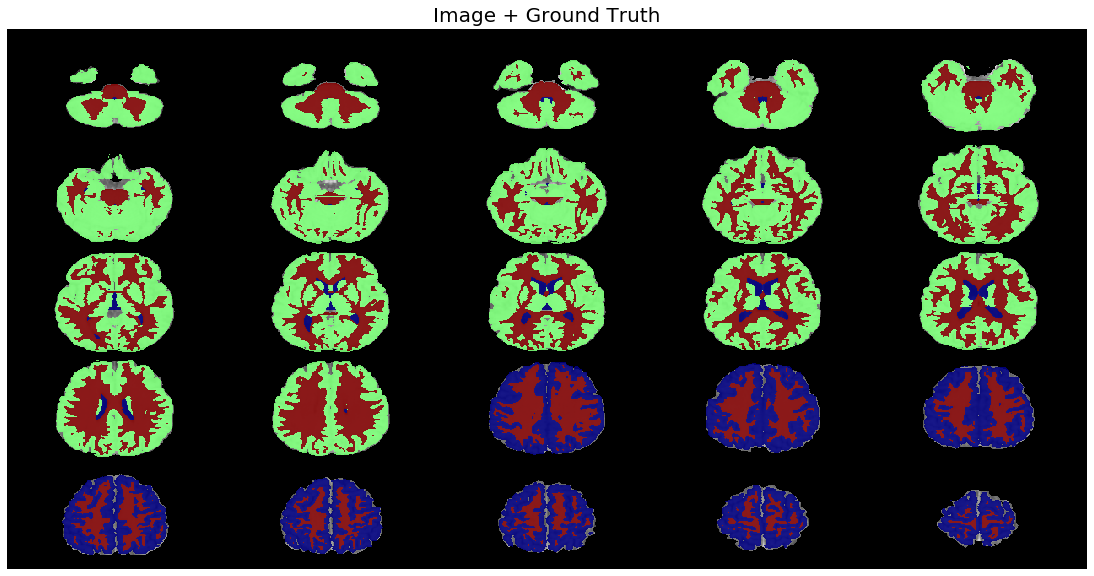

In [0]:
mri_subject = ants.image_read('/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_01/IBSR_T1.nii.gz')
if (NUMBER_OF_LABELS == 4):
  lesion_mask = ants.image_read('/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_01/IBSR_seg.nii.gz')
elif (NUMBER_OF_LABELS == 5):
  lesion_mask = ants.image_read('/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_01/IBSR_seg_5_labels.nii.gz')
mri_subject.plot(overlay=lesion_mask, nslices=25, axis=2, title='Image + Ground Truth')

## 2.1 Loading data efficiently:

Similar to other *Deep Learning* toolkits, Pytorch also incorporates some objects to deal with data efficiently. In particular, we will make use of `Datasets` and `Dataloaders`:

* `Datasets` objects are used to build customs datasets from our data, permitting us to manage training data very efficiently. For instance, imagine a custom dataset with hundreds of MRI subjects containing several input modalities. Loading and managing this amount of information may be tricky in some situations, so a custom `Dataset` that loads the data when necessary is convenient. 

* `Dataloaders` take `Datasets` as input and permits to automatically collate individual fetched data samples into batches via arguments. `Dataloaders` yield consecutive batch samples during the training loop, handling all the data requirements via the `Dataset` object. 

In order to speed up this tutorial, we are going to make use of some helper funcions to deal with MRI data and convert them into PyTorch `dataloaders` (see `utils.py` for more information). 


Let's now train our `Unet` model using the `WMH2017` data. Before start training, several steps have to be taken into account: 
1. Split the available data into training, validation and test sets. 
2. Build the proper training data structures using the PyTorch `Dataset` and `Dataloader` objects.
3. Build the training loop. 

With the aim  to unify all the hyper-parameters and training options, we will define a dictionary `options` that we will populate with new values: 

In [0]:
options = {}

# training data path
options['training_path'] = '/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set'

# training data path
options['training_path_aug'] = '/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended'

# testing data path 
options['validation_path'] = '/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Validation_Set'

# testing data path 
options['test_path'] = '/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Test_Set'

# train/validation split percentage
options['train_split']  = 0.3

# input modality names
options['input_data'] = ['IBSR_T1.nii.gz']

# ground-truth name
if (NUMBER_OF_LABELS == 4):
  options['gt_data'] = 'IBSR_seg.nii.gz'
elif (NUMBER_OF_LABELS == 5):
  options['gt_data'] = 'IBSR_seg_5_labels.nii.gz'

## 2.2 Training generators: 

We are going to use the helper class `MRI_DataPatchLoader` from `utils.py` to generate a `Dataset` object based on our data. `MRI_DataPathLoader` requires an input dictionary with all image paths, image labels, and some other options for patch generation and normalization that we will cover in a few minutes. 

Additionally, the `MRI_DataPathLoader` also requires a third dictionary containing the paths a ROI mask from within the patch sampling should be performed. This mask is very handful to guide the sampling process, for instance to remove background voxels, deal with class imbalance etc...

For our example, let's generate a ROI mask for each subject simply with the binary brain mask:

In [0]:
options['roi'] = 'brainmask.nii.gz'

def mask_image(im):
    return (im > 0).astype('float32')

for scan_id in os.listdir(options['training_path']):
    scan = ants.image_read(os.path.join(options['training_path'], 
                                        scan_id, 
                                        'IBSR_T1.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['training_path'], 
                                       scan_id, 
                                       options['roi']))
    
for scan_id in os.listdir(options['training_path_aug']):
    scan = ants.image_read(os.path.join(options['training_path_aug'], 
                                        scan_id, 
                                        'IBSR_T1.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['training_path_aug'], 
                                       scan_id, 
                                       options['roi']))
                                       
for scan_id in os.listdir(options['validation_path']):
    scan = ants.image_read(os.path.join(options['validation_path'], 
                                        scan_id, 
                                        'IBSR_T1.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['validation_path'], 
                                       scan_id, 
                                       options['roi']))

for scan_id in os.listdir(options['test_path']):
    scan = ants.image_read(os.path.join(options['test_path'], 
                                        scan_id, 
                                        'IBSR_T1.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['test_path'], 
                                       scan_id, 
                                       options['roi']))                                       

Now, we can define the input dictionaries for training and validation: 

In [0]:
training_scans = os.listdir(options['training_path'])
training_scans_aug = os.listdir(options['training_path_aug'])
training_scans.sort()
        
# load training / validation data
t_d = int(len(training_scans) * (1 - options['train_split']))
training_data = training_scans[:t_d]
validation_data = training_scans[t_d:]

input_train_data = {scan: [os.path.join(options['training_path'], scan, d)
                         for d in options['input_data']]
                  for scan in training_data}

input_train_labels = {scan: [os.path.join(options['training_path'], scan, options['gt_data'])] 
                      for scan in training_data}

input_train_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in training_data}

input_train_data_aug = {scan: [os.path.join(options['training_path_aug'], scan, d)
                         for d in options['input_data']]
                  for scan in training_scans_aug}

input_train_labels_aug = {scan: [os.path.join(options['training_path_aug'], scan, options['gt_data'])] 
                      for scan in training_scans_aug}

input_train_rois_aug = {scan: [os.path.join(options['training_path_aug'], scan, options['roi'])] 
                      for scan in training_scans_aug}

input_val_data = {scan: [os.path.join(options['training_path'], scan, d)
                         for d in options['input_data']]
                  for scan in validation_data}

input_val_labels = {scan: [os.path.join(options['training_path'], scan, options['gt_data'])] 
                    for scan in validation_data}

input_val_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in validation_data}
if(DATA_AUGMENTATION):
  input_train_data.update(input_train_data_aug)
  input_train_labels.update(input_train_labels_aug)
  input_train_rois.update(input_train_rois_aug)

In [0]:
input_train_data

{'IBSR_01': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_01/IBSR_T1.nii.gz'],
 'IBSR_01_au_1463_1500': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1463_1500/IBSR_T1.nii.gz'],
 'IBSR_01_au_1602_1250': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1602_1250/IBSR_T1.nii.gz'],
 'IBSR_01_au_1780_1125': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1780_1125/IBSR_T1.nii.gz'],
 'IBSR_03': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_03/IBSR_T1.nii.gz'],
 'IBSR_03_au_1050_1125': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_03_au_10

In [0]:
input_train_labels

{'IBSR_01': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_01/IBSR_seg.nii.gz'],
 'IBSR_01_au_1463_1500': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1463_1500/IBSR_seg.nii.gz'],
 'IBSR_01_au_1602_1250': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1602_1250/IBSR_seg.nii.gz'],
 'IBSR_01_au_1780_1125': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1780_1125/IBSR_seg.nii.gz'],
 'IBSR_03': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_03/IBSR_seg.nii.gz'],
 'IBSR_03_au_1050_1125': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_03_

In [0]:
input_train_rois

{'IBSR_01': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_01/brainmask.nii.gz'],
 'IBSR_01_au_1463_1500': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1463_1500/brainmask.nii.gz'],
 'IBSR_01_au_1602_1250': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1602_1250/brainmask.nii.gz'],
 'IBSR_01_au_1780_1125': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBSR_01_au_1780_1125/brainmask.nii.gz'],
 'IBSR_03': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_03/brainmask.nii.gz'],
 'IBSR_03_au_1050_1125': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set_Intenisty_Size_Augmentation_Extended/IBS

In [0]:
input_val_data

{'IBSR_09': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_09/IBSR_T1.nii.gz'],
 'IBSR_16': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_16/IBSR_T1.nii.gz'],
 'IBSR_18': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_18/IBSR_T1.nii.gz']}

In [0]:
input_val_labels

{'IBSR_09': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_09/IBSR_seg.nii.gz'],
 'IBSR_16': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_16/IBSR_seg.nii.gz'],
 'IBSR_18': ['/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Training_Set/IBSR_18/IBSR_seg.nii.gz']}

Build the `Datasets` for training and validation data. Here, we need to define the patch size (in 3D), and how we are going to sample the images. Also consider image normalization (take it into account on testing also!). We [normalize](https://datascience.stackexchange.com/questions/32109/zero-mean-and-unit-variance) images with `mean=0` and `std=1`. In particular, we are going to use:

* Patch size of `32x32x32`
* Sampling step of `16x16x16`
* Batch size of `32`



In [0]:

def extract_patches(input_image,
                    roi=None,
                    voxel_coords=None,
                    patch_size=(15, 15, 15),
                    step_size=(1, 1, 1)):
    """
    Extract patches of size patch_size from an input image given as input

    inputs:
    - input_image:  3D np.array
    - roi: region of interest to extract samples. input_image > 0 if not set
    - voxel_coords: Already computed voxel coordenades
    - patch_size: output patch size
    - step_size: sampling overlap in x, y and z

    output:
    - list of sampled patches: 4D array [n, patch_size] eg: (100, 15, 15 ,15)
    - list of voxel_coordenates
    """

    # check roi
    if roi is None:
        roi = input_image > 0

    # get voxel coordenates taking into account step sampling if those are
    # not passed as input
    if voxel_coords is None:
        voxel_coords = get_voxel_coordenates(input_image,
                                             roi,
                                             step_size=step_size)

    # extract patches based on the sampled voxel coordenates
    out_patches = get_patches(input_image, voxel_coords, patch_size)

    return out_patches, voxel_coords


def get_voxel_coordenates(input_data,
                          roi,
                          random_pad=(0, 0, 0),
                          step_size=(1, 1, 1)):
    """
    Get voxel coordenates based on a sampling step size or input mask.
    For each selected voxel, return its (x,y,z) coordinate.

    inputs:
    - input_data (useful for extracting non-zero voxels)
    - roi: region of interest to extract samples. input_data > 0 if not set
    - step_size: sampling overlap in x, y and z
    - random_pad: initial random padding applied to indexes

    output:
    - list of voxel coordenates
    """

    # compute initial padding
    r_pad = np.random.randint(random_pad[0]+1) if random_pad[0] > 0 else 0
    c_pad = np.random.randint(random_pad[1]+1) if random_pad[1] > 0 else 0
    s_pad = np.random.randint(random_pad[2]+1) if random_pad[2] > 0 else 0

    # precompute the sampling points based on the input
    sampled_data = np.zeros_like(input_data)
    for r in range(r_pad, input_data.shape[0], step_size[0]):
        for c in range(c_pad, input_data.shape[1], step_size[1]):
            for s in range(s_pad, input_data.shape[2], step_size[2]):
                sampled_data[r, c, s] = 1

    # apply sampled points to roi and extract sample coordenates
    # [x, y, z] = np.where(input_data * roi * sampled_data)
    [x, y, z] = np.where(roi * sampled_data)

    # return as a list of tuples
    return [(x_, y_, z_) for x_, y_, z_ in zip(x, y, z)]


def get_patches(input_data, centers, patch_size=(15, 15, 15)):
    """
    Get image patches of arbitrary size based on a set of voxel coordenates

    inputs:
    - input_data: a tridimensional np.array matrix
    - centers:  centre voxel coordenate for each patch
    - patch_size: patch size (x,y,z)

    outputs:
    - patches: np.array containing each of the patches
    """
    # If the size has even numbers, the patch will be centered. If not,
    # it will try to create an square almost centered. By doing this we allow
    # pooling when using encoders/unets.
    patches = []
    list_of_tuples = all([isinstance(center, tuple) for center in centers])
    sizes_match = [len(center) == len(patch_size) for center in centers]

    if list_of_tuples and sizes_match:
        # apply padding to the input image and re-compute the voxel coordenates
        # according to the new dimension
        padded_image = apply_padding(input_data, patch_size)
        patch_half = tuple([idx // 2 for idx in patch_size])
        new_centers = [map(add, center, patch_half) for center in centers]
        # compute patch locations
        slices = [[slice(c_idx-p_idx, c_idx+s_idx-p_idx)
                   for (c_idx, p_idx, s_idx) in zip(center,
                                                    patch_half,
                                                    patch_size)]
                  for center in new_centers]

        # extact patches
        patches = [padded_image[tuple(idx)] for idx in slices]

    return np.array(patches)


def reconstruct_image(input_data, centers, output_size):
    """
    Reconstruct image based on several ovelapping patch samples

    inputs:
    - input_data: a np.array list with patches
    - centers: center voxel coordenates for each patch
    - output_size: output image size (x,y,z)

    outputs:
    - reconstructed image
    """

    # apply a padding around edges before writing the results
    # recompute the voxel dimensions
    patch_size = input_data[0, :].shape
    out_image = apply_padding(np.zeros(output_size), patch_size)
    patch_half = tuple([idx // 2 for idx in patch_size])
    new_centers = [map(add, center, patch_half) for center in centers]
    # compute patch locations
    slices = [[slice(c_idx-p_idx, c_idx+s_idx-p_idx)
               for (c_idx, p_idx, s_idx) in zip(center,
                                                patch_half,
                                                patch_size)]
              for center in new_centers]

    # for each patch, sum it to the output patch and
    # then update the frequency matrix

    freq_count = np.zeros_like(out_image)

    for patch, slide in zip(input_data, slices):
        out_image[tuple(slide)] += patch
        freq_count[tuple(slide)] += np.ones(patch_size)

    # invert the padding applied for patch writing
    out_image = invert_padding(out_image, patch_size)
    freq_count = invert_padding(freq_count, patch_size)

    # the reconstructed image is the mean of all the patches
    out_image /= freq_count
    out_image[np.isnan(out_image)] = 0

    return out_image


def apply_padding(input_data, patch_size, mode='constant', value=0):
    """
    Apply padding to edges in order to avoid overflow

    """

    patch_half = tuple([idx // 2 for idx in patch_size])
    padding = tuple((idx, size-idx)
                    for idx, size in zip(patch_half, patch_size))

    padded_image = np.pad(input_data,
                          padding,
                          mode=mode,
                          constant_values=value)

    return padded_image


def invert_padding(padded_image, patch_size):
    """
    Invert paadding on edges to recover the original shape

    inputs:
    - padded_image defined by apply_padding function
    - patch_size (x,y,z)

    """

    patch_half = tuple([idx // 2 for idx in patch_size])
    padding = tuple((idx, size-idx)
                    for idx, size in zip(patch_half, patch_size))

    return padded_image[padding[0][0]:-padding[0][1],
                        padding[1][0]:-padding[1][1],
                        padding[2][0]:-padding[2][1]]

def normalize_data(im,
                   norm_type=NORMALIZATION_TYPE,
                   brainmask=None,
                   datatype=np.float32):
    """
    Zero mean normalization

    inputs:
    - im: input data
    - nomr_type: 'zero_one', 'standard'

    outputs:
    - normalized image
    """
    mask = np.copy(im > 0 if brainmask is None else brainmask)

    if norm_type == 'standard':
        im = im.astype(dtype=datatype) - im[np.nonzero(im)].mean()
        im = im / im[np.nonzero(im)].std()

    if norm_type == 'zero_one':
        min_int = abs(im.min())
        max_int = im.max()
        if im.min() < 0:
            im = im.astype(dtype=datatype) + min_int
            im = im / (max_int + min_int)
        else:
            im = (im.astype(dtype=datatype) - min_int) / max_int

    # do not apply normalization to non-brain parts
    # im[mask==0] = 0
    return im



In [0]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset
from operator import add

class MRI_DataPatchLoader(Dataset):
    """
    Data loader experiments

    """

    def __init__(self,
                 input_data,
                 labels,
                 rois,
                 patch_size,
                 sampling_step,
                 random_pad=(0, 0, 0),
                 sampling_type='mask',
                 normalize=False,
                 min_sampling_th=0,
                 num_pos_samples=5000,
                 resample_epoch=False,
                 transform=None):
        """
        Arguments:
        - input_data: dict containing a list of inputs for each training scan
        - labels: dict containing a list of labels for each training scan
        - roi: dict containing a list of roi masks for each training scan
        - patch_size: patch size
        - sampling_step: sampling_step
        - sampling type: 'all: all voxels in input_mask,
                         'roi: all voxels in roi_mask,
                         'balanced: same number of positive and negative voxels
        - normalize: Normalize data (0 mean / 1 std)
        - min_sampling_th: Minimum value to extract samples (0 default)
        - num_pos_samples used when hybrid sampling
        - transform
        """

        self.patch_size = patch_size
        self.sampling_step = sampling_step
        self.random_pad = random_pad
        self.sampling_type = sampling_type
        self.patch_half = tuple([idx // 2 for idx in self.patch_size])
        self.normalize = normalize
        self.min_th = min_sampling_th
        self.resample_epoch = resample_epoch
        self.transform = transform
        self.num_pos_samples = num_pos_samples

        # preprocess scans

        # load MRI scans in memory
        self.input_scans, self.label_scans, self.roi_scans = self.load_scans(input_data,
                                                                             labels,
                                                                             rois,
                                                                             apply_padding=True)
        
        
        self.num_modalities = len(self.input_scans[0])
        self.input_train_dim = (self.num_modalities, ) + self.patch_size
        self.input_label_dim = (1, ) + self.patch_size

        # normalize scans if set update
        if normalize:
            self.input_scans = [[normalize_data(self.input_scans[i][m])
                                for m in range(self.num_modalities)]
                                for i in range(len(self.input_scans))]

        # Build the patch indexes based on the image index and the voxel
        # coordenates

        self.patch_indexes = self.generate_patch_indexes(self.roi_scans)

        print('> DATA: Training sample size:', len(self.patch_indexes))

    def __len__(self):
        """
        Get the legnth of the training set
        """
        return len(self.patch_indexes)

    def __getitem__(self, idx):
        """
        Get the next item. Resampling the entire dataset is considered if
        self.resample_epoch is set to True.
        """

        if idx == 0 and self.resample_epoch:
            self.patch_indexes = self.generate_patch_indexes(self.roi_scans)

        im_ = self.patch_indexes[idx][0]
        center = self.patch_indexes[idx][1]

        slice_ = [slice(c_idx-p_idx, c_idx+s_idx-p_idx)
                  for (c_idx, p_idx, s_idx) in zip(center,
                                                   self.patch_half,
                                                   self.patch_size)]

        # get current patches for both training data and labels
        input_train = np.stack([self.input_scans[im_][m][tuple(slice_)]
                                for m in range(self.num_modalities)], axis=0)
        input_label = np.expand_dims(
            self.label_scans[im_][0][tuple(slice_)], axis=0)

        # check dimensions and put zeros if necessary
        if input_train.shape != self.input_train_dim:
            print('error in patch', input_train.shape, self.input_train_dim)
            input_train = np.zeros(self.input_train_dim).astype('float32')
        if input_label.shape != self.input_label_dim:
            print('error in label')
            input_label = np.zeros(self.input_label_dim).astype('float32')

        if self.transform:
            input_train, input_label = self.transform([input_train,
                                                       input_label])

        return input_train, input_label

    def apply_padding(self, input_data, mode='constant', value=0):
        """
        Apply padding to edges in order to avoid overflow

        """

        padding = tuple((idx, size-idx)
                        for idx, size in zip(self.patch_half, self.patch_size))
        
   
        padded_image = np.pad(input_data,
                              padding,
                              mode=mode,
                              constant_values=value)

        return padded_image

    def load_scans(self,
                   input_data,
                   label_data,
                   roi_data,
                   apply_padding=True,
                   apply_canonical=False):
        """
        Applying padding to input scans. Loading simultaneously input data and
        labels in order to discard missing data in both sets.
        """

        input_scans = []
        label_scans = []
        roi_scans = []

        

        for s in input_data.keys():
            """
            for i in range(len(input_data[s])):
              dummy = nib.load(input_data[s][i]).get_data()
              if(dummy.ndim ==4):
                plt.imshow(dummy[128,:,:,0])
                plt.show()
             
              elif(dummy.ndim ==3):
                plt.imshow(dummy[128,:,:])
                plt.show()
              print(dummy.shape)
            """
            try:
                if apply_padding:

                    for i in range(len(input_data[s])):
                      input_load = nib.load(input_data[s][i]).get_data().astype('float32')
                      if(input_load.ndim ==4):
                        input_ = [self.apply_padding(np.squeeze(input_load,axis=3))]
                      elif(input_load.ndim ==3):
                        input_ = [self.apply_padding(input_load)]
                    
                    for i in range(len(label_data[s])):

                      label_load = nib.load(label_data[s][i]).get_data().astype('float32')
                      if(label_load.ndim ==4):
                        label_ = [self.apply_padding(np.squeeze(label_load,axis=3))]
                      elif(label_load.ndim ==3):
                        label_ = [self.apply_padding(label_load)]

                      
                      
                    
                    roi_ = [self.apply_padding(nib.load(roi_data[s][i]).get_data().astype('float32'))for i in range(len(roi_data[s]))]
                    input_scans.append(input_)
                    label_scans.append(label_)
                    roi_scans.append(roi_)
                    print('> DATA: Loaded scan', s,
                          'roi size:',  np.sum(roi_[0] > 0),
                          'label_size: ', np.sum(label_[0] > 0))
                else:

                    for i in range(len(input_data[s])):
                      input_load = nib.load(input_data[s][i]).get_data().astype('float32')
                      if(input_load.ndim ==4):
                        input_ = [(np.squeeze(nib.load(input_data[s][i]).get_data().astype('float32'),axis=3))]
                      elif(input_load.ndim ==3):
                        input_ = [(nib.load(input_data[s][i]).get_data().astype('float32'))]
                    
                    for i in range(len(label_data[s])):
                      label_load = nib.load(label_data[s][i]).get_data().astype('float32')
                      if(label_load.ndim ==4):
                        label_ = [(np.squeeze(nib.load(label_data[s][i]).get_data().astype('float32'),axis=3))]
                      elif(label_load.ndim ==3):
                        label_ = [(nib.load(label_data[s][i]).get_data().astype('float32'))]



                    
                    roi_ = [(nib.load(roi_data[s][i]).get_data().astype('float32')) for i in range(len(roi_data[s]))]
                    input_scans.append(input_)
                    label_scans.append(label_)
                    roi_scans.append(roi_)
                    print('> DATA: Loaded scan', s, 'roi size:',
                          np.sum(roi_[0] > 0))
            except:
                print('> DATA: Error loading scan', s, '... Discarding')
                

        return input_scans, label_scans, roi_scans

    def generate_patch_indexes(self, roi_scans):
        """
        Generate indexes to extract. Consider the sampling step and
        a initial random padding
        """
        training_indexes = []
        # patch_half = tuple([idx // 2 for idx in self.patch_size])
        for s, l, r, i in zip(self.input_scans,
                              self.label_scans,
                              roi_scans,
                              range(len(self.input_scans))):

            # sample candidates
            candidate_voxels = self.get_candidate_voxels(s[0], l[0], r[0])
            voxel_coords = get_voxel_coordenates(s[0],
                                                 candidate_voxels,
                                                 step_size=self.sampling_step,
                                                 random_pad=self.random_pad)
            training_indexes += [(i, tuple(v)) for v in voxel_coords]

        return training_indexes

    def get_candidate_voxels(self, input_mask, label_mask, roi_mask):
        """
        Sample input mask using different techniques:
        - all: extracts all voxels > 0 from the input_mask
        - mask: extracts all roi voxels
        - balanced: same number of positive and negative voxels from
                    the input_mask as defined by the roi mask
        - balanced+roi: same number of positive and negative voxels from
                    the roi and label mask

        - hybrid sampling:
          1. Set a number of positive samples == self.pos_samples
          2. Displace randomly its x, y, z position < self.patch_half
          3. Get the same number of negative samples from the roi mask
        """

        if self.sampling_type == 'image':
            sampled_mask = input_mask > 0

        if self.sampling_type == 'all':
            sampled_mask = input_mask > 0

        if self.sampling_type == 'mask':
            sampled_mask = roi_mask > 0

        if self.sampling_type == 'balanced':
            sampled_mask = label_mask > 0
            num_positive = np.sum(label_mask > 0)
            brain_voxels = np.stack(np.where(input_mask > self.min_th), axis=1)
            for voxel in np.random.permutation(brain_voxels)[:num_positive]:
                sampled_mask[voxel[0], voxel[1], voxel[2]] = 1

        if self.sampling_type == 'balanced+roi':
            sampled_mask = label_mask > 0
            num_positive = np.sum(label_mask > 0)
            roi_mask[label_mask == 1] = 0
            brain_voxels = np.stack(np.where(roi_mask > 0), axis=1)
            for voxel in np.random.permutation(brain_voxels)[:num_positive]:
                sampled_mask[voxel[0], voxel[1], voxel[2]] = 1

        if self.sampling_type == 'hybrid':
            x, y, z = np.where(label_mask > 0)
            number_of_samples = len(x)

            # sample voxels randomly until size equals self.num_samples
            if number_of_samples < self.num_pos_samples:
                expand_interval = int(self.num_pos_samples / number_of_samples) + 1
                x = np.repeat(x, expand_interval)
                y = np.repeat(y, expand_interval)
                z = np.repeat(z, expand_interval)

            index_perm = np.random.permutation(range(len(x)))
            x = x[index_perm][:self.num_pos_samples]
            y = y[index_perm][:self.num_pos_samples]
            z = z[index_perm][:self.num_pos_samples]

            # randomize the voxel center
            min_int_x = - self.patch_half[0] +1
            max_int_x = self.patch_half[0] -1
            min_int_y = - self.patch_half[1] +1
            max_int_y = self.patch_half[1] -1
            min_int_z = - self.patch_half[2] +1
            max_int_z = self.patch_half[2] -1
            x += np.random.randint(low=min_int_x,
                                   high=max_int_x,
                                    size=x.shape)
            y += np.random.randint(low=min_int_y,
                                   high=max_int_y,
                                   size=y.shape)
            z += np.random.randint(low=min_int_z,
                                   high=max_int_z,
                                   size=z.shape)

            # check boundaries
            x = np.maximum(self.patch_half[0], x)
            x = np.minimum(label_mask.shape[0] - self.patch_half[0], x)
            y = np.maximum(self.patch_half[1], y)
            y = np.minimum(label_mask.shape[1] - self.patch_half[1], y)
            z = np.maximum(self.patch_half[2], z)
            z = np.minimum(label_mask.shape[2] - self.patch_half[2], z)

            # assign the same number of positive and negative voxels
            sampled_mask = np.zeros_like(label_mask)

            # positive samples
            for x_v, y_v, z_v in zip(x, y, z):
                sampled_mask[x, y, z] = 1

            # negative samples
            brain_voxels = np.stack(np.where(roi_mask > 0), axis=1)
            for voxel in np.random.permutation(brain_voxels)[:self.num_pos_samples]:
                sampled_mask[voxel[0], voxel[1], voxel[2]] = 1

        return sampled_mask


  

/usr/local/lib/python3.6/dist-packages/nibabel/testing/__init__.py:21: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


In [0]:
#from MAIA_seminar.utils import MRI_DataPatchLoader
from torch.utils.data import DataLoader

# additional options for patch size, sampling step, normalization, etc...
options['patch_size'] = (32, 32, 32)
options['sampling_step'] = (BLOCK_STEP_SIZE, BLOCK_STEP_SIZE, BLOCK_STEP_SIZE)
options['normalize'] = True 
options['batch_size'] = BATCH_SIZE

print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_train_data,
                                       labels=input_train_labels,
                                       rois=input_train_rois,
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'])

training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)

print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_val_data,
                                        labels=input_val_labels,
                                        rois=input_val_rois,
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

Training data: 
> DATA: Loaded scan IBSR_01 roi size: 1147470 label_size:  1093813
> DATA: Loaded scan IBSR_03 roi size: 951358 label_size:  899576
> DATA: Loaded scan IBSR_04 roi size: 1069342 label_size:  1027700
> DATA: Loaded scan IBSR_05 roi size: 1040178 label_size:  950111
> DATA: Loaded scan IBSR_06 roi size: 1078395 label_size:  977824
> DATA: Loaded scan IBSR_07 roi size: 867764 label_size:  799514
> DATA: Loaded scan IBSR_08 roi size: 868943 label_size:  787260
> DATA: Loaded scan IBSR_08_au_347_1250 roi size: 1689677 label_size:  1533613
> DATA: Loaded scan IBSR_08_au_246_1500 roi size: 2744500 label_size:  2505056
> DATA: Loaded scan IBSR_03_au_1387_1250 roi size: 1851822 label_size:  1755550
> DATA: Loaded scan IBSR_01_au_1780_1125 roi size: 1630404 label_size:  1548237
> DATA: Loaded scan IBSR_03_au_1050_1125 roi size: 1359803 label_size:  1286104
> DATA: Loaded scan IBSR_04_au_1125_1250 roi size: 2058862 label_size:  1984862
> DATA: Loaded scan IBSR_05_au_1970_1125 roi 

# 3. Training the network:

---


Finally we can build our training loop to optimize the `Unet` model based on the same principles we covered in the first part of this tutorial. Basically, what we are going to do is to iterate the training dataset for a number of epochs, saving the weights of the model accordingly. 

For this first example, we are going to use the [cross-entropy](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) loss and the [Adadelta](https://pytorch.org/docs/stable/optim.html#torch.optim.Adadelta) optimizer:



In [0]:
def dice_coef_multi(true_out, pred_out, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    
    class_num = NUMBER_OF_LABELS
    for i in range(class_num):
        y_pred_f = torch.flatten(pred_out[:,i,:,:,:])
        y_true_f = torch.flatten(true_out[:,0,:,:,:]==i)
        intersection = torch.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return (1 - total_loss)

In [0]:
from torch.optim import Adadelta,Adam
import sys
import shutil
try:
    shutil.rmtree("/content/models3")
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))

# mkdir for stored models
!mkdir models3
CUDA_LAUNCH_BLOCKING=1

# Define the Unet model 
if(UNET_TYPE == 1):
  lesion_model = Unet_3_Layers(input_size=1, output_size=NUMBER_OF_LABELS)
  print("U-Net Architecture: U-Net 3 Layers")
elif(UNET_TYPE == 2):
  lesion_model = Unet_3_Layers_BN(input_size=1, output_size=NUMBER_OF_LABELS)
  print("U-Net Architecture: U-Net 3 Layers with BatchNormaliztion")
elif(UNET_TYPE == 3):
  lesion_model = Unet_3_Layers_BN_DO(input_size=1, output_size=NUMBER_OF_LABELS)
  print("U-Net Architecture: U-Net 3 Layers with BatchNormaliztion and Dropouts")
elif(UNET_TYPE == 4):
  lesion_model = Unet_4_Layers_BN_DO(input_size=1, output_size=NUMBER_OF_LABELS)
  print("U-Net Architecture: U-Net 4 Layers with BatchNormaliztion and Dropouts")
elif(UNET_TYPE == 5):
  lesion_model = Modified3DUNet(in_channels =1, n_classes=NUMBER_OF_LABELS)
  print("U-Net Architecture: Modified U-Net")
elif(UNET_TYPE == 6):
  lesion_model =ResUNet(in_channel=1, n_classes=NUMBER_OF_LABELS)#not good
  print("U-Net Architecture: Residual U-Net")
elif(UNET_TYPE == 7):
  lesion_model =R2U_Net(img_ch=1, output_ch=NUMBER_OF_LABELS)#is so bad
  print("U-Net Architecture: R2U-Net")
elif(UNET_TYPE == 8):
  lesion_model =NestedUNet(in_ch=1, out_ch=NUMBER_OF_LABELS)#GPU memory limit
  print("U-Net Architecture: Nested U-Net")

#model_name = 'test_maia_wmh'

# some training options
options['gpu_use'] = True
options['num_epochs'] = NUMBER_OF_EPOCHS

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# define the optimizer
if(OPTIMIZER_FUNCTION == 1):
  optimizer = Adadelta(lesion_model.parameters(), lr=0.25)
  print("Optimizer Function: Adadelta")
elif(OPTIMIZER_FUNCTION == 2):
  optimizer = Adam(lesion_model.parameters(), lr=0.003)
  print("Optimizer Function: Adam")


# send the model to the device
lesion_model = lesion_model.to(device)


training_metrics=np.zeros((options['num_epochs'],4))

# training loop
training = True
epoch = 1
try:
    while training:
        print('Epoch: {}/{}'.format(epoch,options['num_epochs']))

    
        # epoch specific metrics
        train_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0
        
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        lesion_model.train()
        for b_train, batch in enumerate(Bar(training_dataloader)):
                # process batches: each batch is composed by training (x) and labels (y)
                # x = [32, 2, 32, 32, 32]
                # y = [32, 1, 32, 32, 32]
    
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # clear gradients
                optimizer.zero_grad()
                
                # infer the current batch 
                pred = lesion_model(x)
                
                # compute the loss.
                if(LOSS_FUNCTION == 1):
                  loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)), y.squeeze(dim=1).long())
                elif(LOSS_FUNCTION == 2):
                  loss = dice_coef_multi(y,pred)


                train_loss += loss.item()
                
                # backward loss and next step
                loss.backward()
              
                optimizer.step()

                # compute the accuracy
                pred = pred.max(1, keepdim=True)[1]
                batch_accuracy = pred.eq(y.view_as(pred).long())
                train_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)
                
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into train mode
        lesion_model.eval()
        for b_val, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # infer the current batch 
                with torch.no_grad():
                    pred = lesion_model(x)
                
                    # compute the loss. 
                    if(LOSS_FUNCTION == 1):
                      loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)), y.squeeze(dim=1).long())
                    elif(LOSS_FUNCTION == 2):
                      loss = dice_coef_multi(y,pred)


                    val_loss += loss.item()
                
                    # compute the accuracy 
                    pred = pred.max(1, keepdim=True)[1]
                    batch_accuracy = pred.eq(y.view_as(pred).long())
                    val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)
        
        # compute mean metrics
        train_loss /= (b_train + 1)
        train_accuracy /= (b_train + 1)
        val_loss /= (b_val + 1)
        val_accuracy /= (b_val + 1)

        print('Epoch {:d}: train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
            epoch, 
            train_loss, 
            train_accuracy,
            val_loss,
            val_accuracy))
        
        training_metrics[(epoch - 1),[0,1,2,3]]=[train_loss, train_accuracy, val_loss, val_accuracy]
        # update epochs
        epoch += 1
        
        # save weights
        torch.save(lesion_model.state_dict(), 
                  os.path.join('models3', 'model' + str(epoch) + '.pt'))

        if epoch >= options['num_epochs']+1:
            training = False
except KeyboardInterrupt:
    pass

U-Net Architecture: U-Net 3 Layers with BatchNormaliztion and Dropouts
Optimizer Function: Adam
Epoch: 1/5
102129/102129: [===============================>] - ETA 0.9s
Epoch 1: train_loss 0.1808 train_acc 0.8787 val_loss 0.1062 val_acc 0.9107
Epoch: 2/5
102129/102129: [===============================>] - ETA 0.9s
Epoch 2: train_loss 0.1101 train_acc 0.9020 val_loss 0.0889 val_acc 0.9206
Epoch: 3/5
102129/102129: [===============================>] - ETA 0.9s
Epoch 3: train_loss 0.0962 train_acc 0.9120 val_loss 0.0888 val_acc 0.9213
Epoch: 4/5
102129/102129: [===============================>] - ETA 0.9s
Epoch 4: train_loss 0.0895 train_acc 0.9173 val_loss 0.0840 val_acc 0.9253
Epoch: 5/5
102129/102129: [===============================>] - ETA 0.9s
Epoch 5: train_loss 0.0865 train_acc 0.9199 val_loss 0.0918 val_acc 0.9175


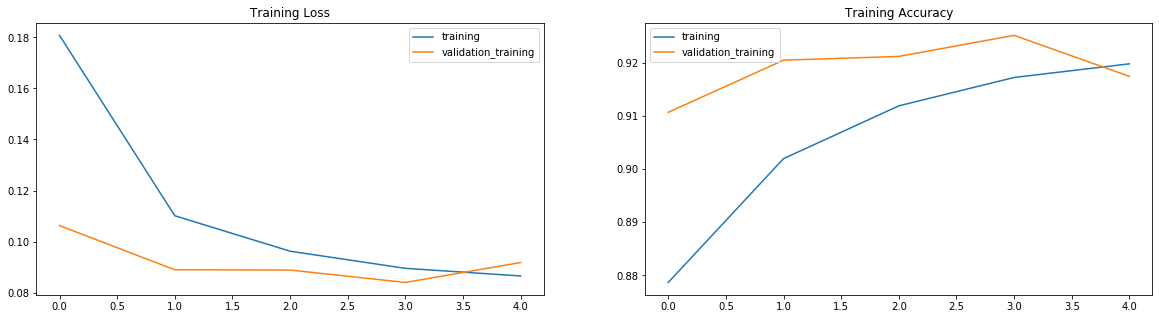

In [0]:
fig=plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
plt.plot(training_metrics[:,[0,2]])
plt.legend(["training","validation_training"])
plt.title('Training Loss') 
fig.add_subplot(1, 2, 2)
plt.plot(training_metrics[:,[1,3]])
plt.legend(["training","validation_training"])
plt.title('Training Accuracy') 
plt.show()

# 4. Inference:

---


Once we have trained our first `Unet` model, we can infer some testing cases to see how well it performs. In contrast to training, we do not make use of data generators for infering lesions on testing scans. Again, we are  going to use some additional helper functions included in `utils.py` that will help us to extract the image patches to infer the model:

* `get_inference_patches` will extract $[num_{samples}, 2, 32, 32, 32]$ patches from the input image along with their coordenates $(x,y,z)$. 

* `reconstruct_image` will take the predicted patches and reconstruct them back as an image using the coordinates as a  base. 

In [0]:
def get_inference_patches(scan_path, input_data, roi, patch_shape, step, normalize=True):
    """
    Get patches for inference

    inputs:
    - scan path: path/to/the/subject to infer
    - input_data: list containing the input modality names
    - roi: ROI mask name
    - patch_shape: patch size
    - step: sampling step
    - normalize = zero mean normalization

    outputs:
    - test patches (samples, channels, x, y, z)
    - ref voxels coordenates  extracted

    """


    # get candidate voxels
    mask_image = nib.load(os.path.join(scan_path, roi))

    

    ref_mask, ref_voxels = get_candidate_voxels(mask_image.get_data(),
                                                step,
                                                sel_method='all')

    # input images stacked as channels
    test_patches = get_data_channels(scan_path,
                                     input_data,
                                     ref_voxels,
                                     patch_shape,
                                     step,
                                     normalize=normalize)


    return test_patches, ref_voxels


def get_data_channels(image_path,
                      scan_names,
                      ref_voxels,
                      patch_shape,
                      step,
                      normalize=False):
    """
    Get data for each of the channels
    """
    out_patches = []
    for s in scan_names:
        current_scan = os.path.join(image_path, s)
        patches, _ = get_input_patches(current_scan,
                                       ref_voxels,
                                       patch_shape,
                                       step,
                                       normalize=normalize)
        out_patches.append(patches)

    return np.concatenate(out_patches, axis=1)


def get_input_patches(scan_path,
                      ref_voxels,
                      patch_shape,
                      step,
                      normalize=False,
                      expand_dims=True):
    """
    get current patches for a given scan
    """
    # current_scan = nib.as_closest_canonical(nib.load(scan_path)).get_data()
    current_scan = np.squeeze(nib.load(scan_path).get_data(),axis=3)

    if normalize:
        current_scan = normalize_data(current_scan)

    patches, ref_voxels = extract_patches(current_scan,
                                          voxel_coords=ref_voxels,
                                          patch_size=patch_shape,
                                          step_size=step)

    if expand_dims:
        patches = np.expand_dims(patches, axis=1)

    return patches, ref_voxels


def get_candidate_voxels(input_mask,  step_size, sel_method='all'):
    """
    Extract candidate patches.
    """

    if sel_method == 'all':
        candidate_voxels = input_mask > 0

        voxel_coords = get_voxel_coordenates(input_mask,
                                             candidate_voxels,
                                             step_size=step_size)
    return candidate_voxels, voxel_coords

# 5. Evaluation:
---

In order to evaluate the results, we use standard metrics for lesion segmentation such as:
* `DSC:` Dice **segmentation** coefficient 
* `TPF:` **Lesion-wise** true positive rate (Sensitivity) 
* `PPV:` **Lesion-wise** positive predictive value (PPV)(precision)

Let's infer all the test images and evaluate the results in average:

We evaluate the model on the extracted patches. Note that inference is very similar to validation, but we store the results in the `lesion_out` array:

Finally, we reconstruct the image based on the inferred patches and binarize the output. Here by default we use threshold of $th=0.5$, but other can be considered:

##Validation Set

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Validation_Set/IBSR_13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in true_divide


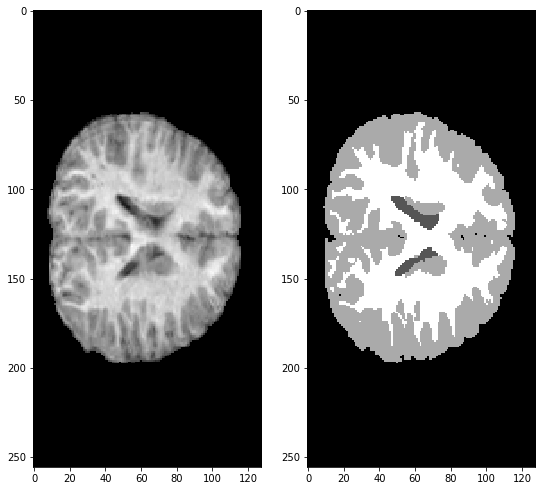

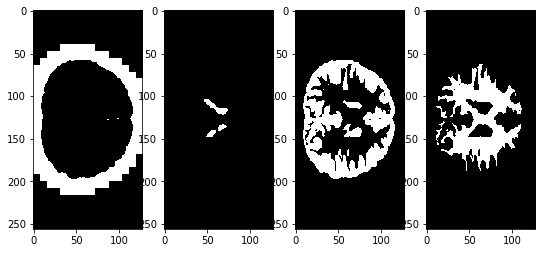

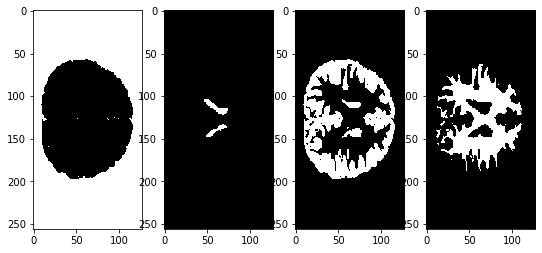

/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Validation_Set/IBSR_12


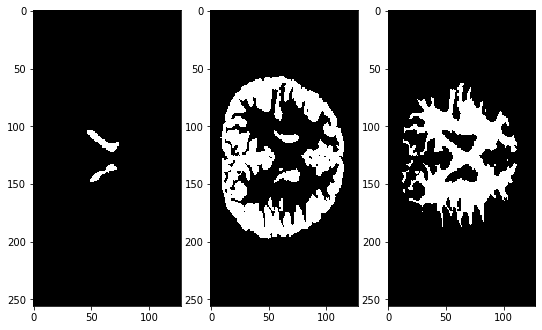

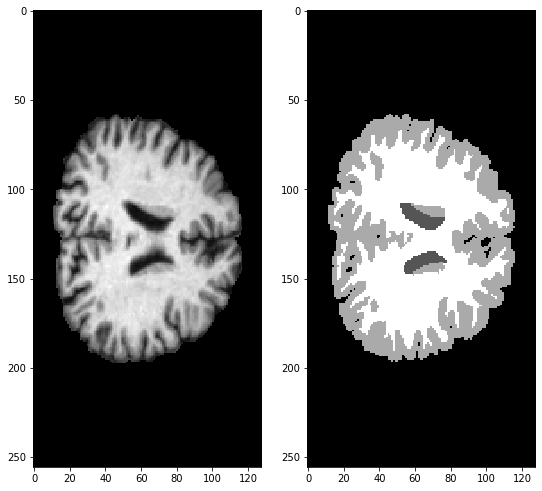

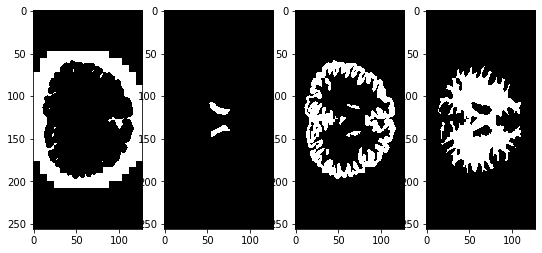

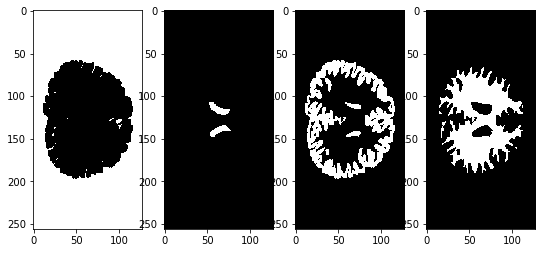

/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Validation_Set/IBSR_17


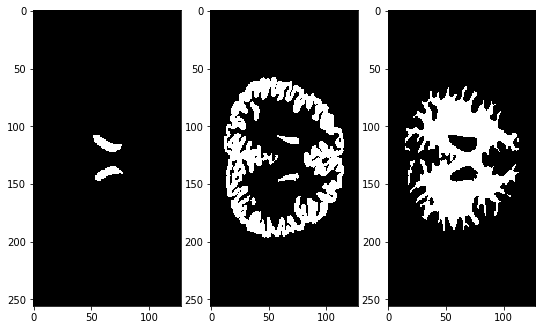

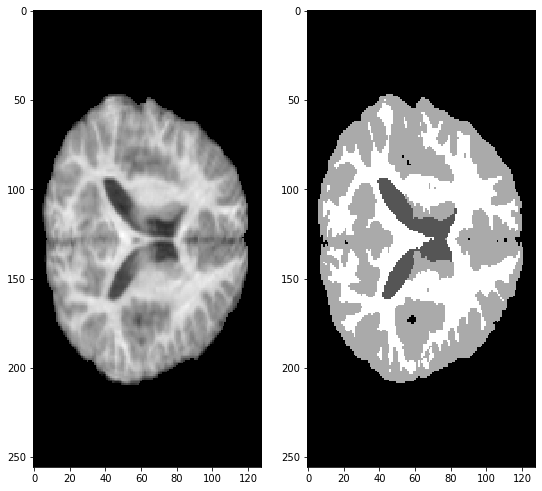

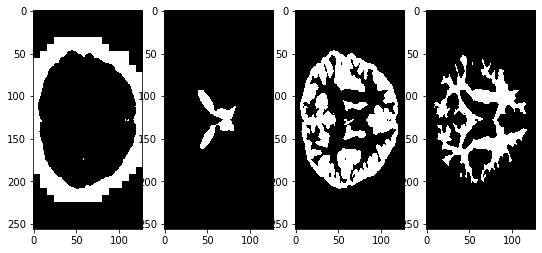

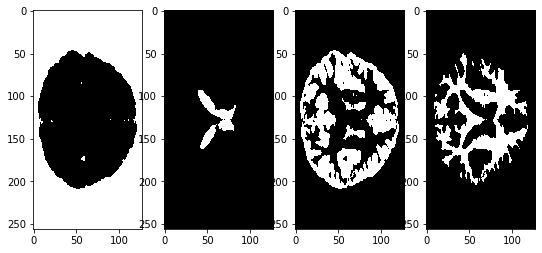

/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Validation_Set/IBSR_14


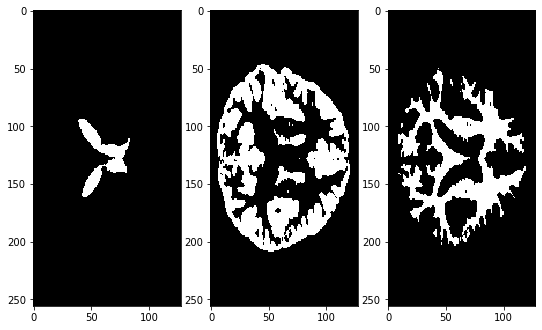

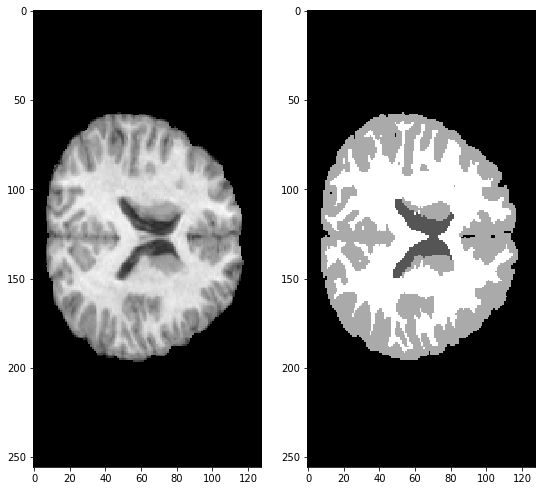

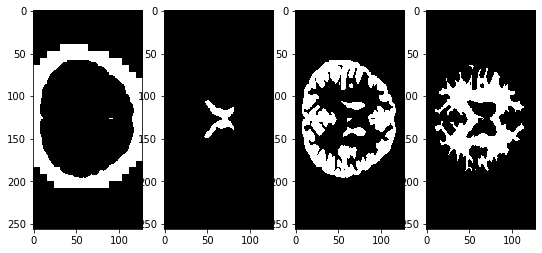

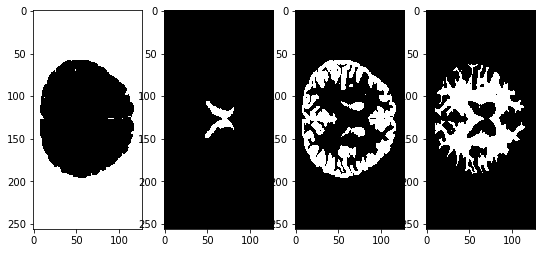

/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Validation_Set/IBSR_11


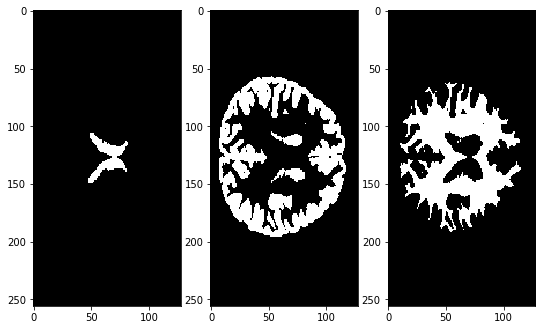

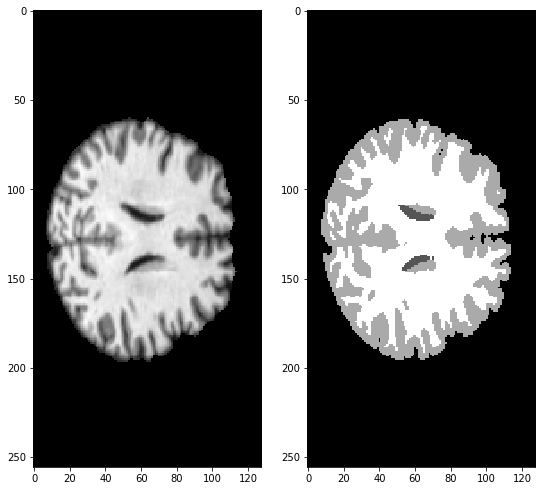

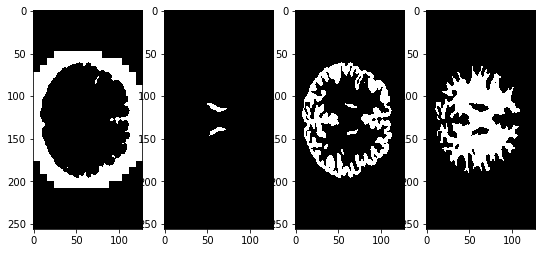

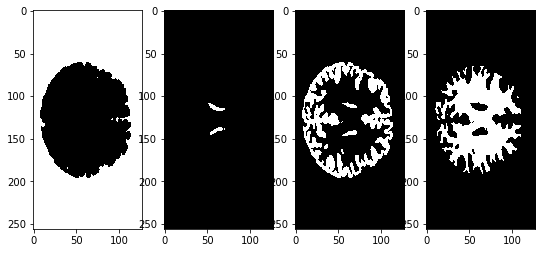

,count,mean,std,min,25%,50%,75%,max
DSC CSF:,5.0,0.904598,0.019130,0.880504,0.894931,0.899502,0.921893,0.926157
DSC GM:,5.0,0.932696,0.005723,0.924351,0.930209,0.933361,0.936547,0.939015
DSC WM:,5.0,0.922201,0.018585,0.901643,0.906246,0.921893,0.936980,0.944243
TPF CSF:,5.0,0.384679,0.129647,0.187500,0.384615,0.384615,0.416667,0.550000
TPF GM:,5.0,0.500000,0.117851,0.333333,0.500000,0.500000,0.500000,0.666667
TPF WM:,5.0,0.264243,0.142150,0.028846,0.254902,0.289474,0.356688,0.391304
PPV CSF:,5.0,0.734696,0.226064,0.396226,0.697674,0.712230,0.867347,1.000000
PPV GM:,5.0,0.354291,0.056510,0.269565,0.353846,0.356725,0.362745,0.428571
PPV WM:,5.0,0.358928,0.125520,0.206107,0.283672,0.337918,0.447839,0.519104


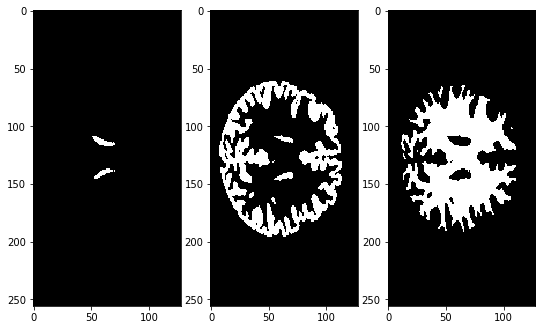

In [0]:
import pandas as pd
from MAIA_seminar.metrics import DSC_seg, TPF_det, PPV_det
import matplotlib.pyplot as plt
slice_no = 150

enable_plot = True

# obtain a list of test scans
test_scans = os.listdir(options['validation_path'])
th = 0.5

# iterate through the scans and evaluate the results
metrics = np.zeros((len(test_scans), 9))

for i, scan_name in enumerate(test_scans):
    
    scan_path = os.path.join(options['validation_path'], scan_name)
    print(scan_path)

    #from MAIA_seminar.utils import get_inference_patches, reconstruct_image
    scan = ants.image_read(os.path.join(scan_path, 'IBSR_T1.nii.gz'))
    if(NUMBER_OF_LABELS == 4):
      scan_labels = ants.image_read(os.path.join(scan_path, 'IBSR_seg.nii.gz'))
    elif(NUMBER_OF_LABELS == 5):
      scan_labels = ants.image_read(os.path.join(scan_path, 'IBSR_seg_5_labels.nii.gz'))

    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                          input_data=options['input_data'],
                                          roi=options['roi'],
                                          patch_shape=options['patch_size'],
                                          step=options['sampling_step'],
                                          normalize=options['normalize'])
    if(enable_plot):
      plt.figure(figsize=(9,9))
      plt.subplot(1,2,1)
      plt.imshow(scan[:,:,slice_no], cmap='gray')
      plt.subplot(1,2,2)
      plt.imshow(scan_labels[:,:,slice_no], cmap='gray')
    
    lesion_out = np.zeros((infer_patches.shape[0],NUMBER_OF_LABELS,infer_patches.shape[2],infer_patches.shape[3],infer_patches.shape[4])).astype('float32')
    batch_size = options['batch_size']

    # model evaluation 
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(lesion_out), batch_size):
            x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
            pred = lesion_model(x)
            lesion_out[b:b+batch_size] = pred.cpu().numpy()

    # reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
    lesion_prob_BG = reconstruct_image(lesion_out[:,0], coordenates, scan.shape)
    lesion_prob_CSF = reconstruct_image(lesion_out[:,1], coordenates, scan.shape)
    lesion_prob_GM = reconstruct_image(lesion_out[:,2], coordenates, scan.shape)
    lesion_prob_WM = reconstruct_image(lesion_out[:,3], coordenates, scan.shape)
    if(NUMBER_OF_LABELS==5):
      lesion_prob_RN = reconstruct_image(lesion_out[:,4], coordenates, scan.shape)

    lesion_prob_BG = (lesion_prob_BG > th).astype('uint8')
    lesion_prob_CSF = (lesion_prob_CSF > th).astype('uint8')
    lesion_prob_GM = (lesion_prob_GM > th).astype('uint8')
    lesion_prob_WM = (lesion_prob_WM > th).astype('uint8')
    if(NUMBER_OF_LABELS==5):
      lesion_prob_RN = (lesion_prob_RN > th).astype('uint8')
    
    if(enable_plot):
      if(NUMBER_OF_LABELS==4):
          plt.figure(figsize=(9,9))
          plt.subplot(1,4,1)
          plt.imshow(lesion_prob_BG[:,:,slice_no], cmap='gray')
          plt.subplot(1,4,2)
          plt.imshow(lesion_prob_CSF[:,:,slice_no], cmap='gray')
          plt.subplot(1,4,3)
          plt.imshow(lesion_prob_GM[:,:,slice_no], cmap='gray')
          plt.subplot(1,4,4)
          plt.imshow(lesion_prob_WM[:,:,slice_no], cmap='gray')
          plt.show()
          
          plt.figure(figsize=(9,9))
          plt.subplot(1,4,1)
          plt.imshow(scan_labels[:,:,slice_no]==0, cmap='gray')
          plt.subplot(1,4,2)
          plt.imshow(scan_labels[:,:,slice_no]==1, cmap='gray')
          plt.subplot(1,4,3)
          plt.imshow(scan_labels[:,:,slice_no]==2, cmap='gray')
          plt.subplot(1,4,4)
          plt.imshow(scan_labels[:,:,slice_no]==3, cmap='gray')
          plt.show()

      if(NUMBER_OF_LABELS==5):
          plt.figure(figsize=(9,9))
          plt.subplot(1,5,1)
          plt.imshow(lesion_prob_BG[:,:,slice_no], cmap='gray')
          plt.subplot(1,5,2)
          plt.imshow(lesion_prob_CSF[:,:,slice_no], cmap='gray')
          plt.subplot(1,5,3)
          plt.imshow(lesion_prob_GM[:,:,slice_no], cmap='gray')
          plt.subplot(1,5,4)
          plt.imshow(lesion_prob_WM[:,:,slice_no], cmap='gray')
          plt.subplot(1,5,5)
          plt.imshow(lesion_prob_RN[:,:,slice_no], cmap='gray')
          plt.show()

          plt.figure(figsize=(9,9))
          plt.subplot(1,5,1)
          plt.imshow(scan_labels[:,:,slice_no]==0, cmap='gray')
          plt.subplot(1,5,2)
          plt.imshow(scan_labels[:,:,slice_no]==1, cmap='gray')
          plt.subplot(1,5,3)
          plt.imshow(scan_labels[:,:,slice_no]==2, cmap='gray')
          plt.subplot(1,5,4)
          plt.imshow(scan_labels[:,:,slice_no]==3, cmap='gray')
          plt.subplot(1,5,5)
          plt.imshow(scan_labels[:,:,slice_no]==4, cmap='gray')
          plt.show()



    # evaluate the results    
    gt = ants.image_read(os.path.join(scan_path, 'IBSR_seg.nii.gz'))
    gt_CSF = (gt.numpy() == 1)
    gt_GM = (gt.numpy() == 2)
    gt_WM = (gt.numpy() == 3)

    if(enable_plot):
      plt.figure(figsize=(9,9))
      plt.subplot(1,3,1)
      plt.imshow(gt_CSF[:,:,slice_no], cmap='gray')
      plt.subplot(1,3,2)
      plt.imshow(gt_GM[:,:,slice_no], cmap='gray')
      plt.subplot(1,3,3)
      plt.imshow(gt_WM[:,:,slice_no], cmap='gray')

    dsc_metric_CSF = DSC_seg(gt_CSF, lesion_prob_CSF)
    dsc_metric_GM = DSC_seg(gt_GM, lesion_prob_GM)
    dsc_metric_WM = DSC_seg(gt_WM, lesion_prob_WM)

    tpf_metric_CSF = TPF_det(gt_CSF, lesion_prob_CSF)
    tpf_metric_GM = TPF_det(gt_GM, lesion_prob_GM)
    tpf_metric_WM = TPF_det(gt_WM, lesion_prob_WM)

    ppv_metric_CSF = PPV_det(gt_CSF, lesion_prob_CSF)
    ppv_metric_GM = PPV_det(gt_GM, lesion_prob_GM)
    ppv_metric_WM = PPV_det(gt_WM, lesion_prob_WM)

    #print(dsc_metric_CSF)
    #print(dsc_metric_WM)
    #print(dsc_metric_GM)

    metrics[i] = [dsc_metric_CSF, dsc_metric_GM, dsc_metric_WM, tpf_metric_CSF, tpf_metric_GM, tpf_metric_WM, ppv_metric_CSF, ppv_metric_GM, ppv_metric_WM]
        
    #print('SCAN:', scan_name, 'Dice: ', dsc_metric, 'TPF:', tpf_metric, 'PPV:', ppv_metric)

#we use PANDAS to describe data :)
m = pd.DataFrame(metrics, columns=['DSC CSF: ', 'DSC GM: ', 'DSC WM: ', 'TPF CSF: ', 'TPF GM: ', 'TPF WM: ', 'PPV CSF: ', 'PPV GM: ', 'PPV WM: '])
m.describe().T




##Testing Set

/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Test_Set/IBSR_02


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in true_divide


/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Test_Set/IBSR_10
/content/drive/My Drive/Colab Notebooks/MISA_final_project/Dataset_Modified/Test_Set/IBSR_15


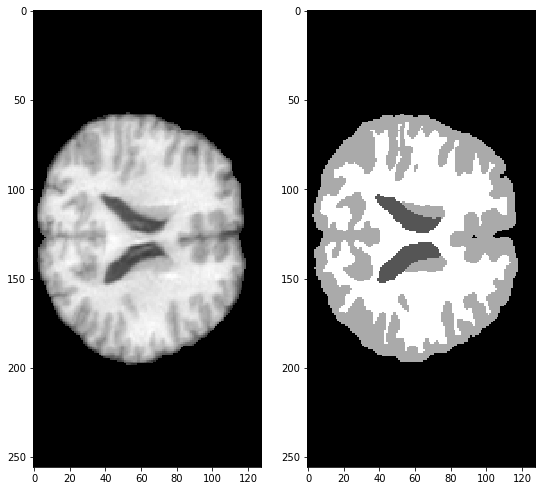

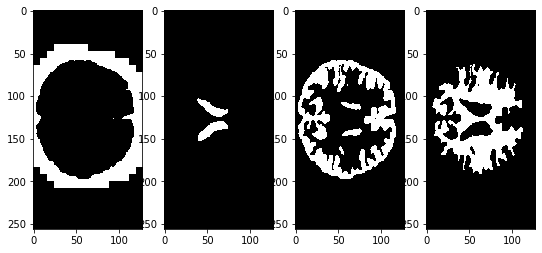

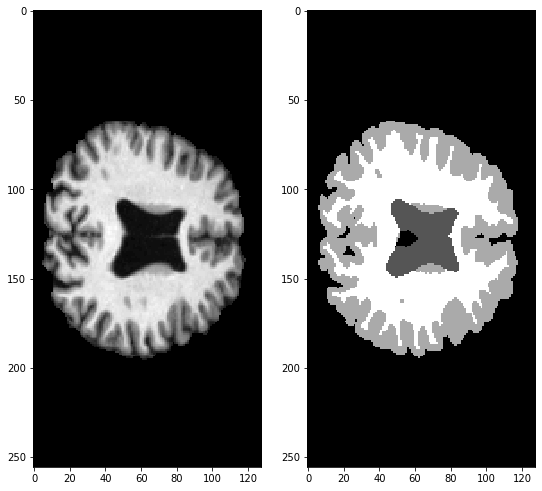

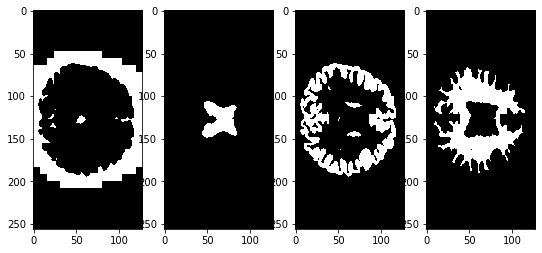

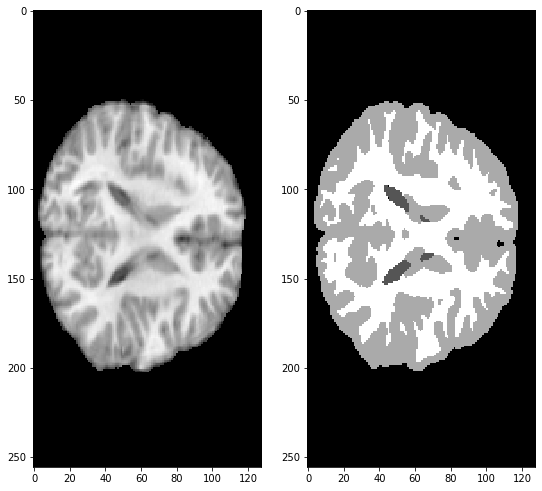

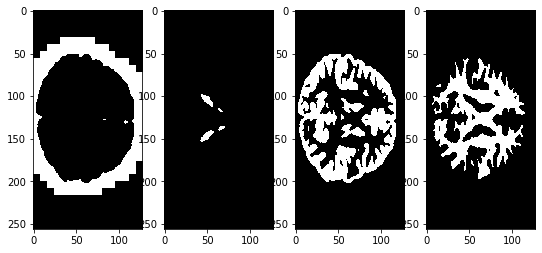

In [0]:
import nibabel as nib

plot_stat = False

# obtain a list of test scans
test_scans = os.listdir(options['test_path'])
th = 0.5

# iterate through the scans and evaluate the results
metrics = np.zeros((len(test_scans), 9))

for i, scan_name in enumerate(test_scans):
    scan_path = os.path.join(options['test_path'], scan_name)
    print(scan_path)



    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                      input_data=options['input_data'],
                                      roi=options['roi'],
                                      patch_shape=options['patch_size'],
                                      step=options['sampling_step'],
                                      normalize=options['normalize'])
    lesion_out = np.zeros((infer_patches.shape[0],NUMBER_OF_LABELS,infer_patches.shape[2],infer_patches.shape[3],infer_patches.shape[4])).astype('float32')
    batch_size = options['batch_size']

        # model evaluation 
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(lesion_out), batch_size):
            x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
            pred = lesion_model(x)
            lesion_out[b:b+batch_size] = pred.cpu().numpy()

    # reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
    lesion_prob_BG = reconstruct_image(lesion_out[:,0], coordenates, scan.shape)
    lesion_prob_CSF = reconstruct_image(lesion_out[:,1], coordenates, scan.shape)
    lesion_prob_GM = reconstruct_image(lesion_out[:,2], coordenates, scan.shape)
    lesion_prob_WM = reconstruct_image(lesion_out[:,3], coordenates, scan.shape)
    if (NUMBER_OF_LABELS == 5):
      lesion_prob_RN = reconstruct_image(lesion_out[:,4], coordenates, scan.shape)

    lesion_prob_BG = (lesion_prob_BG > th).astype('uint8')
    lesion_prob_CSF = (lesion_prob_CSF > th).astype('uint8')
    lesion_prob_GM = (lesion_prob_GM > th).astype('uint8')
    lesion_prob_WM = (lesion_prob_WM > th).astype('uint8')
    if (NUMBER_OF_LABELS == 5):
      lesion_prob_RN = (lesion_prob_RN > th).astype('uint8')


    #scan_img = nib.load(os.path.join(scan_path, 'IBSR_T1.nii.gz'))

    scan_img_load = nib.load(os.path.join(scan_path, 'IBSR_T1.nii.gz'))
    
    scan_img = np.squeeze(scan_img_load.get_data().astype('float32'),axis=3)
    
    plt.figure(figsize=(9,9))
    plt.subplot(1,2,1)
    plt.imshow(scan_img[:,:,slice_no], cmap='gray')
    
    lesion_final = lesion_prob_CSF + lesion_prob_GM*2 + lesion_prob_WM*3;
    lesion_final[lesion_final>3] = 0
    
    plt.subplot(1,2,2)
    plt.imshow(lesion_final[:,:,slice_no], cmap='gray')

    save_img = nib.Nifti1Image(lesion_final, scan_img_load.affine, scan_img_load.header)
    #nib.save(save_img, os.path.join(scan_path, scan_name+'_lesion_final.nii.gz'))

    if (NUMBER_OF_LABELS == 4):
      plt.figure(figsize=(9,9))
      plt.subplot(1,4,1)
      plt.imshow(lesion_prob_BG[:,:,slice_no], cmap='gray')
      plt.subplot(1,4,2)
      plt.imshow(lesion_prob_CSF[:,:,slice_no], cmap='gray')
      plt.subplot(1,4,3)
      plt.imshow(lesion_prob_GM[:,:,slice_no], cmap='gray')
      plt.subplot(1,4,4)
      plt.imshow(lesion_prob_WM[:,:,slice_no], cmap='gray')
    elif (NUMBER_OF_LABELS == 5):
      plt.figure(figsize=(9,9))
      plt.subplot(1,5,1)
      plt.imshow(lesion_prob_BG[:,:,slice_no], cmap='gray')
      plt.subplot(1,5,2)
      plt.imshow(lesion_prob_CSF[:,:,slice_no], cmap='gray')
      plt.subplot(1,5,3)
      plt.imshow(lesion_prob_GM[:,:,slice_no], cmap='gray')
      plt.subplot(1,5,4)
      plt.imshow(lesion_prob_WM[:,:,slice_no], cmap='gray')
      plt.subplot(1,5,5)
      plt.imshow(lesion_prob_RN[:,:,slice_no], cmap='gray')

